In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv("online_retail.csv")

In [48]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDow"] = df["InvoiceDate"].dt.dayofweek
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

In [49]:
df["Cancel"] = df["Quantity"] < 0

<Axes: xlabel='InvoiceDow', ylabel='count'>

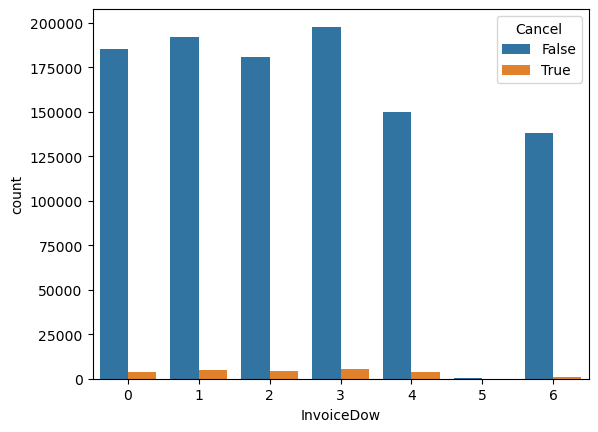

In [50]:
df['Cancel'] = df['Cancel'].astype(str)

sns.countplot(data=df, x='InvoiceDow', hue='Cancel')

In [5]:
df['InvoiceYM'] = df['InvoiceDate'].astype(str).str[:7]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,Cancel,InvoiceYM
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,1,False,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,False,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,False,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,1,False,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,1,False,2009-12


In [6]:
df["InvoiceTime"] = df["InvoiceDate"].dt.time
df["InvoiceHour"] = df["InvoiceDate"].dt.hour
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,Cancel,InvoiceYM,InvoiceTime,InvoiceHour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,1,False,2009-12,07:45:00,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,False,2009-12,07:45:00,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,False,2009-12,07:45:00,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,1,False,2009-12,07:45:00,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,1,False,2009-12,07:45:00,7


In [7]:
df=df[~df["Invoice"].str.contains("C", na=False)]

In [8]:
df= df[(df["Quantity"]>0)]

In [9]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [10]:
today_date = dt.datetime(2011, 12, 11)

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df["TotalPrice"] = df["Quantity"]*df["Price"]

In [13]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (today_date - date.max()).days, 
    'Invoice': lambda num: num.nunique(),  
    'TotalPrice': lambda TotalPrice: TotalPrice.sum()  
})

In [14]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [15]:
#구매기록이 없는 고객 제거
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [16]:
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40
...,...,...,...
18283.0,4,22,2736.65
18284.0,432,1,461.68
18285.0,661,1,427.00


In [17]:
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

In [18]:
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [19]:
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [20]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str) +
                    rfm['MonetaryScore'].astype(str))

In [21]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

In [22]:
rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)

In [23]:
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,5,5,255,Cant_Loose
12347.0,3,8,5633.32,5,4,5,545,Champions
12348.0,76,5,2019.40,3,4,4,344,Loyal_Customers
12349.0,19,4,4428.69,5,3,5,535,Potential_Loyalists
12350.0,311,1,334.40,2,1,2,212,Hibernating
...,...,...,...,...,...,...,...,...
18283.0,4,22,2736.65,5,5,4,554,Champions
18284.0,432,1,461.68,1,2,2,122,Hibernating
18285.0,661,1,427.00,1,2,2,122,Hibernating


In [24]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])
rfm

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,5,5,255,Cant_Loose
12347.0,3,8,5633.32,5,4,5,545,Champions
12348.0,76,5,2019.40,3,4,4,344,Loyal_Customers
12349.0,19,4,4428.69,5,3,5,535,Potential_Loyalists
12350.0,311,1,334.40,2,1,2,212,Hibernating
...,...,...,...,...,...,...,...,...
18283.0,4,22,2736.65,5,5,4,554,Champions
18284.0,432,1,461.68,1,2,2,122,Hibernating
18285.0,661,1,427.00,1,2,2,122,Hibernating


In [25]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count","min", "median", "max"])

Recency                         Frequency            \
                           mean count  min median  max       mean count min   
Segment                                                                       
About_to_Sleep       107.618557   388   60   94.0  190   1.360825   388   1   
At_Risk              373.942667   750  191  377.0  734   3.904000   750   2   
Cant_Loose           331.802817    71  193  326.0  577  15.929577    71   8   
Champions              9.250000   852    1    9.0   20  19.217136   852   4   
Hibernating          460.012484  1522  191  435.0  739   1.252300  1522   1   
Loyal_Customers       68.306016  1147   22   54.0  190   9.803836  1147   4   
Need_Attention       114.241636   269   60  107.0  190   3.156134   269   2   
New_Customers         11.303571    56    1   11.0   20   1.000000    56   1   
Potential_Loyalists   26.297335   713    1   24.0   59   2.589060   713   1   
Promising             39.281818   110   22   38.5   59   1.000000   110   1   

                                     Monetary                          \
                    median  max          mean count     min    median   
Segment                                                                 
About_to_Sleep         1.0    2    531.969905   388    6.20   370.175   
At_Risk                4.0    8   1383.596253   750   38.92   965.510   
Cant_Loose            11.0  155   8355.677634    71  628.32  3881.890   
Champions             11.5  398  10795.520581   852  357.00  4009.870   
Hibernating            1.0    2    437.963135  1522    2.95   285.205   
Loyal_Customers        8.0  107   4199.728592  1147   30.95  2602.320   
Need_Attention         3.0    4   1283.114015   269  120.90   977.170   
New_Customers          1.0    1    356.257857    56   43.20   262.680   
Potential_Loyalists    3.0    4   1155.427281   713   20.80   692.190   
Promising              1.0    1    324.497000   110   30.00   221.620   

                                
                           max  
Segment                         
About_to_Sleep         5416.32  
At_Risk               44534.30  
Cant_Loose            77556.46  
Champions            608821.65  
Hibernating           13916.34  
Loyal_Customers      144458.37  
Need_Attention        39916.50  
New_Customers          3861.00  
Potential_Loyalists  168472.50  
Promising              1635.66

In [26]:
# Step 2: 원가를 판매가의 50% ~ 70% 범위로 임의로 산정
df['Cost'] = df['Price'] * np.random.uniform(0.5, 0.7, size=len(df))

# Step 3: 물품별 판매가와 원가 집계
product_discount_df = df.groupby('StockCode').agg({
    'Price': 'sum',     # 판매가 총합
    'Cost': 'sum',      # 원가 총합
    'Description': 'first'  # 물품 설명 (중복된 설명 중 첫 번째 값 사용)
}).reset_index()

# Step 4: 이익률 계산
product_discount_df['Profit_Margin'] = (product_discount_df['Price'] - product_discount_df['Cost']) / product_discount_df['Price']

# Step 5: 할인율 계산 (목표 이익률 20% 유지)
target_profit_margin = 0.20
product_discount_df['Discount_Rate'] = (product_discount_df['Cost'] / product_discount_df['Price']) * (1 - target_profit_margin)

# Step 6: 결과 출력 (상위 10개의 물품만 출력)
print(product_discount_df.head(10))

# 결과를 CSV 파일로 저장
output_file_path = 'product_discount_calculations.csv'
product_discount_df.to_csv(output_file_path, index=False)


  StockCode   Price        Cost                  Description  Profit_Margin  \
0     10002  386.23  232.067535  INFLATABLE POLITICAL GLOBE        0.399147   
1    10002R   15.40    8.091653        ROBOT PENCIL SHARPNER       0.474568   
2     10080   14.14    8.439377     GROOVY CACTUS INFLATABLE       0.403156   
3     10109    0.42    0.269333         BENDY COLOUR PENCILS       0.358730   
4     10120   18.37   10.802031                 DOGGY RUBBER       0.411974   
5    10123C   52.41   31.399035        HEARTS WRAPPING TAPE        0.400896   
6    10123G   13.95    8.674976      ARMY CAMO WRAPPING TAPE       0.378138   
7    10124A    7.98    4.752938  SPOTS ON RED BOOKCOVER TAPE       0.404394   
8    10124G    5.04    3.080086     ARMY CAMO BOOKCOVER TAPE       0.388872   
9     10125  168.61  102.101997      MINI FUNKY DESIGN TAPES       0.394449   

   Discount_Rate  
0       0.480683  
1       0.420346  
2       0.477475  
3       0.513016  
4       0.470420  
5       0.479283

In [27]:
product_discount_df = pd.read_csv('product_discount_calculations.csv')

In [28]:
product_discount_df.head()

,StockCode,Price,Cost,Description,Profit_Margin,Discount_Rate
0,10002,386.23,232.067535,INFLATABLE POLITICAL GLOBE,0.399147,0.480683
1,10002R,15.40,8.091653,ROBOT PENCIL SHARPNER,0.474568,0.420346
2,10080,14.14,8.439377,GROOVY CACTUS INFLATABLE,0.403156,0.477475
3,10109,0.42,0.269333,BENDY COLOUR PENCILS,0.358730,0.513016
4,10120,18.37,10.802031,DOGGY RUBBER,0.411974,0.470420


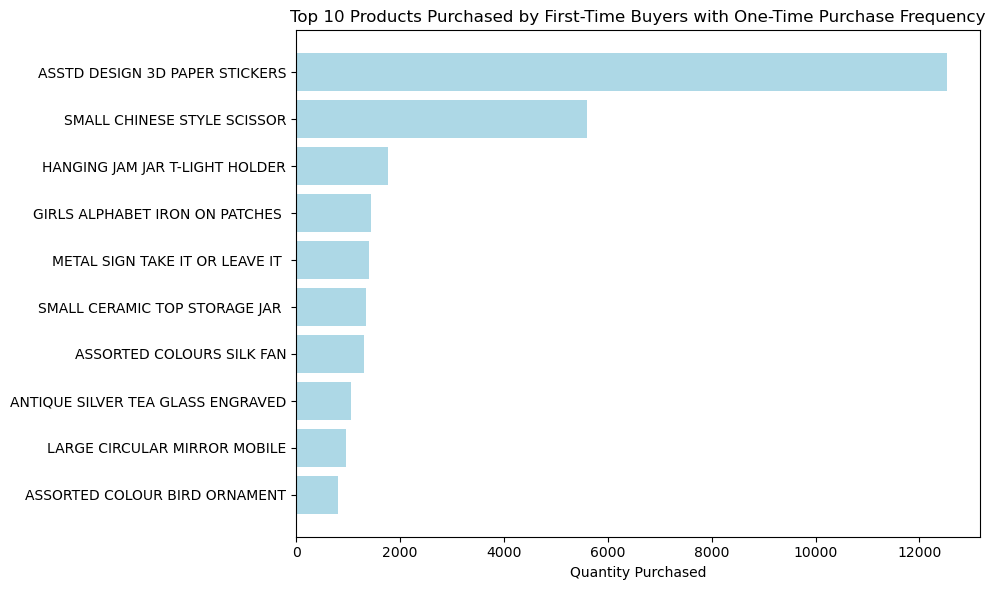

In [29]:
first_purchase_df = df.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase_df.columns = ['Customer ID', 'FirstPurchaseDate']  # 열 이름에 공백이 없는지 확인

df = pd.merge(df, first_purchase_df, on='Customer ID')

first_purchase_products = df[df['InvoiceDate'] == df['FirstPurchaseDate']]

customer_purchase_frequency = first_purchase_products.groupby('Customer ID').size().reset_index(name='Frequency')

one_time_customers = customer_purchase_frequency[customer_purchase_frequency['Frequency'] == 1]

one_time_first_purchase_products = first_purchase_products[first_purchase_products['Customer ID'].isin(one_time_customers['Customer ID'])]

top_first_purchase_products = one_time_first_purchase_products.groupby('Description')['Quantity'].sum().reset_index()

top_first_purchase_products = top_first_purchase_products.sort_values(by='Quantity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_first_purchase_products['Description'], top_first_purchase_products['Quantity'], color='lightblue')
plt.xlabel('Quantity Purchased')
plt.title('Top 10 Products Purchased by First-Time Buyers with One-Time Purchase Frequency')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805620 entries, 0 to 805619
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Invoice            805620 non-null  object        
 1   StockCode          805620 non-null  object        
 2   Description        805620 non-null  object        
 3   Quantity           805620 non-null  int64         
 4   InvoiceDate        805620 non-null  datetime64[ns]
 5   Price              805620 non-null  float64       
 6   Customer ID        805620 non-null  float64       
 7   Country            805620 non-null  object        
 8   InvoiceYear        805620 non-null  int32         
 9   InvoiceMonth       805620 non-null  int32         
 10  InvoiceDay         805620 non-null  int32         
 11  InvoiceDow         805620 non-null  int32         
 12  Cancel             805620 non-null  object        
 13  InvoiceYM          805620 non-null  object  

In [31]:
product_discount_df = pd.read_csv('product_discount_calculations.csv')

In [32]:
product_discount_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4985 entries, 0 to 4984
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   StockCode      4985 non-null   object 
 1   Price          4985 non-null   float64
 2   Cost           4985 non-null   float64
 3   Description    4921 non-null   object 
 4   Profit_Margin  4917 non-null   float64
 5   Discount_Rate  4917 non-null   float64
dtypes: float64(4), object(2)
memory usage: 233.8+ KB


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805620 entries, 0 to 805619
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Invoice            805620 non-null  object        
 1   StockCode          805620 non-null  object        
 2   Description        805620 non-null  object        
 3   Quantity           805620 non-null  int64         
 4   InvoiceDate        805620 non-null  datetime64[ns]
 5   Price              805620 non-null  float64       
 6   Customer ID        805620 non-null  float64       
 7   Country            805620 non-null  object        
 8   InvoiceYear        805620 non-null  int32         
 9   InvoiceMonth       805620 non-null  int32         
 10  InvoiceDay         805620 non-null  int32         
 11  InvoiceDow         805620 non-null  int32         
 12  Cancel             805620 non-null  object        
 13  InvoiceYM          805620 non-null  object  

In [33]:
general_sales = df[df['Quantity'] > 0]['TotalPrice'].sum()

In [34]:
general_sales

17743429.178000003

In [85]:
df_with_discount = pd.merge(df, product_discount_df[['StockCode', 'Discount_Rate']], how='left', on='StockCode')

In [86]:
df = pd.read_csv("online_retail.csv")

In [87]:
df["Cancel"] = df["Quantity"] < 0

In [88]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDow"] = df["InvoiceDate"].dt.dayofweek
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

<Axes: xlabel='InvoiceDow', ylabel='count'>

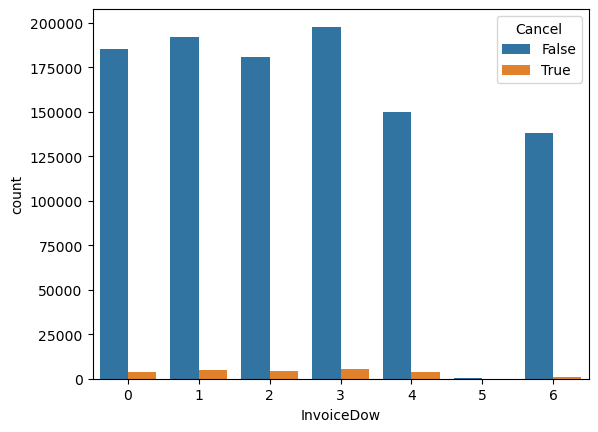

In [89]:
df['Cancel'] = df['Quantity'] < 0
df['Cancel'] = df['Cancel'].astype(str)  # 문자열로 변환
cancel_customers = df[df['Cancel'] == 'True']  # 문자열 'True'로 필터링

sns.countplot(data=df, x='InvoiceDow', hue='Cancel')

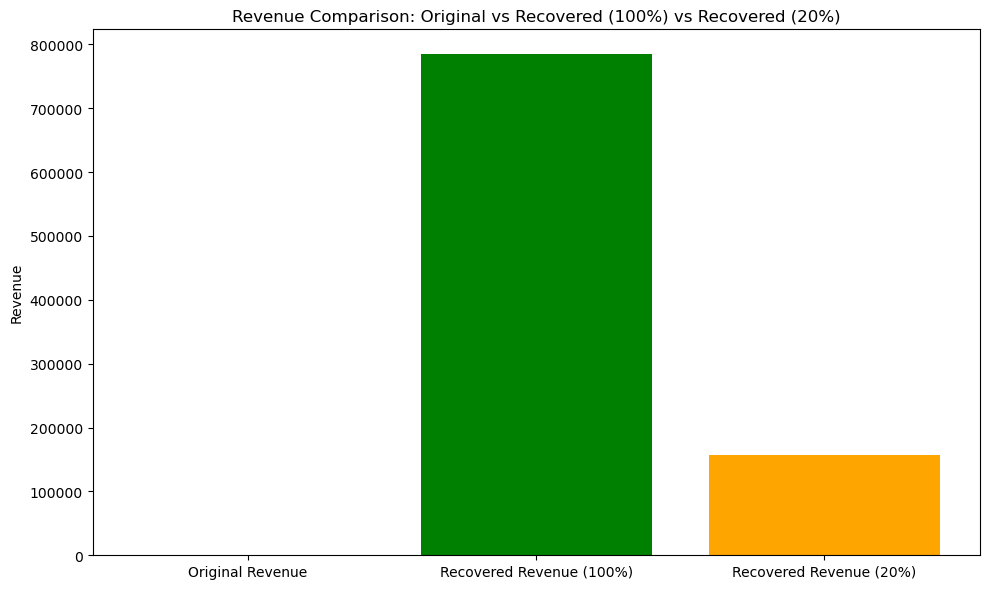

In [90]:
df["TotalPrice"] = df["Quantity"]*df["Price"]

cancel_customers = pd.merge(cancel_customers, product_discount_df[['StockCode', 'Discount_Rate']], on='StockCode', how='left')

# 할인율 적용 후 다시 계산된 매출 (환불을 취소한다고 가정)
cancel_customers['Recovered_Revenue'] = cancel_customers['Quantity'].abs() * cancel_customers['Price'] * (1 - cancel_customers['Discount_Rate'])

# 기존 취소되지 않은 매출 + 환불을 취소한 매출
recovered_total_revenue = total_revenue + cancel_customers['Recovered_Revenue'].sum()

# 3. 취소된 고객 중 20%만 환불을 취소한 매출 계산
# 일부(20%) 고객만 환불을 취소했다고 가정
partial_recovered_revenue = cancel_customers['Recovered_Revenue'].sum() * 0.20

# 기존 취소되지 않은 매출 + 일부(20%) 환불 취소한 매출
partial_recovered_total_revenue = total_revenue + partial_recovered_revenue

# 결과 시각화
revenues = [total_revenue, recovered_total_revenue, partial_recovered_total_revenue]
labels = ['Original Revenue', 'Recovered Revenue (100%)', 'Recovered Revenue (20%)']

plt.figure(figsize=(10, 6))
plt.bar(labels, revenues, color=['blue', 'green', 'orange'])
plt.ylabel('Revenue')
plt.title('Revenue Comparison: Original vs Recovered (100%) vs Recovered (20%)')
plt.tight_layout()
plt.show()

In [83]:
recovered_total_revenue

784224.6584596585

In [91]:
partial_recovered_total_revenue

156844.9316919317